In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import random
import gc
import math

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

In [3]:
# 清空 GPU 缓存
torch.cuda.empty_cache()

# 强制进行垃圾回收
gc.collect()

0

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# 设置随机种子
seed = 12
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 在使用GPU时，还应该设置GPU的随机种子
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [7]:
look_back = 20 #历史时间步
pred_forward = 1 #预测未来时间步
input_sequence_length = 20 #encoder与decoder接收数据长度
epochs = 20 #迭代次数
num_features = 1 #输入特征数
embed_dim = 16 #嵌入维度
dense_dim = 8 #隐藏层神经元个数
num_heads = 2 #头数
dropout_rate = 0.1 #失活率
num_blocks = 2 #编码器解码器数
learn_rate = 0.001 #学习率
batch_size = 32 #批大小

In [8]:
data = pd.read_csv('RV_STL.csv')

In [9]:
data.head()

,datetime,realized_volatility,trend,seasonal
0,2025-06-30 22:15:00,0.000814,0.000938,-0.000138
1,2025-06-30 22:30:00,0.001013,0.000945,-0.000186
2,2025-06-30 22:45:00,0.001262,0.000953,-0.000015
3,2025-06-30 23:00:00,0.001297,0.000961,0.000172
4,2025-06-30 23:15:00,0.001259,0.000969,-0.000022


In [17]:
data_used = data[['realized_volatility']]

In [19]:
data_used.dropna(inplace=True)
data_used.reset_index(inplace=True,drop=True)

C:\Users\RUNCH\AppData\Local\Temp\ipykernel_13124\4034816973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used.dropna(inplace=True)


In [21]:
data_X = data_used.values
data_Y = data_used['realized_volatility'].values

In [23]:
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))

In [25]:
train_size  = int(len(data_X)*0.8)
val_size = int(len(data_X)*0.1)
test_size = len(data_X) - train_size - val_size

In [27]:
train_X,train_Y = data_X[0:train_size], data_Y[0:train_size]
val_X,val_Y = data_X[train_size:train_size+val_size], data_Y[train_size:train_size+val_size]
test_X,test_Y = data_X[train_size+val_size:], data_Y[train_size+val_size:]

In [29]:
scaler1.fit(train_X)  # 使用训练集进行拟合
scaler2.fit(train_Y.reshape(-1, 1))  # 使用训练集进行拟合

train_X = scaler1.transform(train_X)
train_Y = scaler2.transform(train_Y.reshape(-1, 1))

val_X = scaler1.transform(val_X)
val_Y = scaler2.transform(val_Y.reshape(-1, 1))

test_X = scaler1.transform(test_X)
test_Y = scaler2.transform(test_Y.reshape(-1, 1))

In [31]:
# 定义输入数据，输出标签数据的格式的函数，并将数据转换为模型可接受的3D格式
def create_dataset(datasetX, datasetY, look_back = 1, pred_forward = 1):
    dataX, dataY = [], []
    for i in range(0, len(datasetX) - look_back - pred_forward, pred_forward):
        a = datasetX[i:(i + look_back), :]
        dataX.append(a)
        if pred_forward==1:
            dataY.append(datasetY[i + look_back])
        else:
            dataY.append(datasetY[i + look_back:i + look_back + pred_forward,0])
    return np.array(dataX), np.array(dataY)

In [33]:
# 准备训练集和测试集的数据
trainX, trainY = create_dataset(train_X, train_Y, look_back, pred_forward)
valX, valY = create_dataset(val_X,val_Y, look_back, pred_forward)
testX, testY = create_dataset(test_X, test_Y, look_back, pred_forward)

In [35]:
# 转换为PyTorch的Tensor数据
trainX = torch.Tensor(trainX)
trainY = torch.Tensor(trainY)
valX = torch.Tensor(valX)
valY = torch.Tensor(valY)
testX = torch.Tensor(testX)
testY = torch.Tensor(testY)

In [37]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, embed_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, input_sequence_length, embed_dim)
        x = x + self.pe[:, :x.size(1), :].expand(x.size(0), -1, -1)
        return x

In [39]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate):
        super(TransformerEncoder, self).__init__()

        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)

        self.layernorm1 = nn.LayerNorm(embed_dim)

        self.dense1 = nn.Linear(embed_dim, dense_dim)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_dim, embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)

        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

    def forward(self, inputs):
        attn_output, _ = self.mha(inputs, inputs, inputs)

        out1 = self.layernorm1(inputs + self.dropout1(attn_output))

        dense_output = self.dense1(out1)
        dense_output = self.relu(dense_output)
        dense_output = self.dropout2(dense_output)
        dense_output = self.dense2(dense_output)

        out2 = self.layernorm2(out1 + self.dropout3(dense_output))

        return out2

In [41]:
# 构建自定义的Transformer Decoder层
class TransformerDecoder(nn.Module):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate):
        super(TransformerDecoder, self).__init__()

        self.mha1 = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)
        self.mha2 = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)

        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.layernorm3 = nn.LayerNorm(embed_dim)

        self.dense1 = nn.Linear(embed_dim, dense_dim)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_dim, embed_dim)

        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.dropout4 = nn.Dropout(dropout_rate)

    def forward(self, inputs, encoder_outputs,mask=None):
        attn1, _ = self.mha1(inputs, inputs, inputs, attn_mask=mask)
        out1 = self.layernorm1(inputs + self.dropout1(attn1))

        attn2, _ = self.mha2(out1, encoder_outputs, encoder_outputs)
        out2 = self.layernorm2(out1 + self.dropout2(attn2))

        dense_output = self.dense1(out2)
        dense_output = self.relu(dense_output)
        dense_output = self.dropout3(dense_output)
        dense_output = self.dense2(dense_output)

        out3 = self.layernorm3(out2 + self.dropout4(dense_output))

        return out3

In [43]:
# 构建Transformer模型
class Transformer(nn.Module):
    def __init__(self, num_features, embed_dim, dense_dim, num_heads, dropout_rate, num_blocks, look_back, input_sequence_length, output_sequence_length, PE = False, use_mask = False,max_len = 5000):
        super(Transformer, self).__init__()

        self.look_back = look_back
        self.input_sequence_length = input_sequence_length
        self.output_sequence_length = output_sequence_length
        self.PE = PE
        self.use_mask = use_mask
        self.positional_encoding = PositionalEncoding(embed_dim, max_len)
        self.embedding=nn.Linear(num_features, embed_dim)
        self.transformer_encoder = nn.ModuleList([TransformerEncoder(embed_dim, dense_dim, num_heads, dropout_rate) for _ in range(num_blocks)])
        self.transformer_decoder = nn.ModuleList([TransformerDecoder(embed_dim, dense_dim, num_heads, dropout_rate) for _ in range(num_blocks)])
        self.final_layer = nn.Linear(embed_dim * input_sequence_length, output_sequence_length)

    def _generate_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0,1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


    def forward(self, src, tgt=None):
        tgt = src

        if self.use_mask:
            mask = self._generate_mask(tgt.size(1)).to(tgt.device)
        else:
            mask = None

        encoder_inputs = self.embedding(src)
        if self.PE == True:
            encoder_inputs = self.positional_encoding(encoder_inputs)
        for encoder in self.transformer_encoder:
            encoder_inputs = encoder(encoder_inputs)

        decoder_inputs = self.embedding(tgt)
        if self.PE == True:
            decoder_inputs = self.positional_encoding(decoder_inputs)
        for decoder in self.transformer_decoder:
            decoder_inputs = decoder(decoder_inputs, encoder_inputs, mask=mask)

        decoder_outputs = decoder_inputs.view(decoder_inputs.size(0), -1)
        decoder_outputs = self.final_layer(decoder_outputs)
        return decoder_outputs

    def predict_multi_step(self, src, steps):
        predictions = []

        for _ in range(steps):
            # 使用模型进行当前时间步的预测
            output = self.forward(src)

            # 提取当前预测的 volatility (rv)
            predicted_volatility = output[:, -1].unsqueeze(1)  # 形状 [batch size, 1]

            # 拼接新的时间步，保持与输入数据相同的维度
            new_step = predicted_volatility.unsqueeze(1)  # 形状 [batch size, 1, 1]

            # 将新预测的值添加到 src 中，移除最早的时间步
            src = torch.cat((src[:, 1:, :], new_step), dim=1)

            # 记录当前预测结果
            predictions.append(predicted_volatility)

        # 将所有预测结果拼接在一起，形成最终的多步预测结果
        return torch.cat(predictions, dim=1)

In [45]:
# 定义训练集和测试集的数据加载器
class MyDataset(Dataset):
    def __init__(self, data_X, data_Y):
        self.data_X = data_X
        self.data_Y = data_Y

    def __getitem__(self, index):
        x = self.data_X[index]
        y = self.data_Y[index]
        return x, y

    def __len__(self):
        return len(self.data_X)

In [47]:
train_dataset = MyDataset(trainX, trainY)
val_dataset = MyDataset(valX, valY)
test_dataset = MyDataset(testX, testY)

In [49]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [51]:
model = Transformer(num_features, embed_dim, dense_dim, num_heads, dropout_rate, num_blocks, look_back,input_sequence_length, output_sequence_length=pred_forward,PE=True,use_mask=True)
model.to(device)

Transformer(
  (positional_encoding): PositionalEncoding()
  (embedding): Linear(in_features=1, out_features=16, bias=True)
  (transformer_encoder): ModuleList(
    (0-1): 2 x TransformerEncoder(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
      )
      (layernorm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (dense1): Linear(in_features=16, out_features=8, bias=True)
      (relu): ReLU()
      (dense2): Linear(in_features=8, out_features=16, bias=True)
      (layernorm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (dropout3): Dropout(p=0.1, inplace=False)
    )
  )
  (transformer_decoder): ModuleList(
    (0-1): 2 x TransformerDecoder(
      (mha1): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
      )
    

In [52]:
# 定义损失函数和优化器

from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4)

In [53]:
train_losses = []
val_losses = []
# epochs=25
# 训练模型
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0  # 初始化训练损失
    for inputs, labels in tqdm(train_loader, position=0, leave=True):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs,labels)
        # print(outputs.size())
        # print(labels.size())
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    average_train_loss = running_train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # 在验证集上计算损失
    model.eval()
    running_val_loss = 0.0  # 初始化验证损失
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, position=0, leave=True):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

    average_val_loss = running_val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    # 每个 epoch 打印一次训练和验证损失
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {average_train_loss:.8f}, Val Loss: {average_val_loss:.8f}')
    scheduler.step(average_val_loss)

100%|██████████| 21/21 [00:00<00:00, 258.40it/s]


Epoch 1/20, Train Loss: 0.01860200, Val Loss: 0.00342396


100%|██████████| 21/21 [00:00<00:00, 283.09it/s]


Epoch 2/20, Train Loss: 0.00810625, Val Loss: 0.00351675


100%|██████████| 21/21 [00:00<00:00, 312.48it/s]


Epoch 3/20, Train Loss: 0.00621482, Val Loss: 0.00296659


100%|██████████| 21/21 [00:00<00:00, 316.67it/s]


Epoch 4/20, Train Loss: 0.00515254, Val Loss: 0.00259869


100%|██████████| 21/21 [00:00<00:00, 245.05it/s]


Epoch 5/20, Train Loss: 0.00402555, Val Loss: 0.00202299


100%|██████████| 21/21 [00:00<00:00, 294.08it/s]


Epoch 6/20, Train Loss: 0.00321163, Val Loss: 0.00210766


100%|██████████| 21/21 [00:00<00:00, 210.28it/s]


Epoch 7/20, Train Loss: 0.00261290, Val Loss: 0.00156801


100%|██████████| 21/21 [00:00<00:00, 188.96it/s]


Epoch 8/20, Train Loss: 0.00240599, Val Loss: 0.00145646


100%|██████████| 21/21 [00:00<00:00, 292.26it/s]


Epoch 9/20, Train Loss: 0.00220854, Val Loss: 0.00134106


100%|██████████| 21/21 [00:00<00:00, 292.95it/s]


Epoch 10/20, Train Loss: 0.00198662, Val Loss: 0.00187915


100%|██████████| 21/21 [00:00<00:00, 335.04it/s]


Epoch 11/20, Train Loss: 0.00184219, Val Loss: 0.00119641


100%|██████████| 21/21 [00:00<00:00, 334.37it/s]


Epoch 12/20, Train Loss: 0.00178741, Val Loss: 0.00141912


100%|██████████| 21/21 [00:00<00:00, 289.77it/s]


Epoch 13/20, Train Loss: 0.00167835, Val Loss: 0.00319745


100%|██████████| 21/21 [00:00<00:00, 201.91it/s]


Epoch 14/20, Train Loss: 0.00155042, Val Loss: 0.00120791


100%|██████████| 21/21 [00:00<00:00, 345.88it/s]


Epoch 15/20, Train Loss: 0.00163013, Val Loss: 0.00142901


100%|██████████| 21/21 [00:00<00:00, 308.58it/s]


Epoch 16/20, Train Loss: 0.00173927, Val Loss: 0.00177864


100%|██████████| 21/21 [00:00<00:00, 244.01it/s]


Epoch 17/20, Train Loss: 0.00135899, Val Loss: 0.00152473


100%|██████████| 21/21 [00:00<00:00, 326.65it/s]


Epoch 18/20, Train Loss: 0.00135960, Val Loss: 0.00126817


100%|██████████| 21/21 [00:00<00:00, 337.61it/s]


Epoch 19/20, Train Loss: 0.00134474, Val Loss: 0.00109849


100%|██████████| 21/21 [00:00<00:00, 278.30it/s]

Epoch 20/20, Train Loss: 0.00132414, Val Loss: 0.00117099


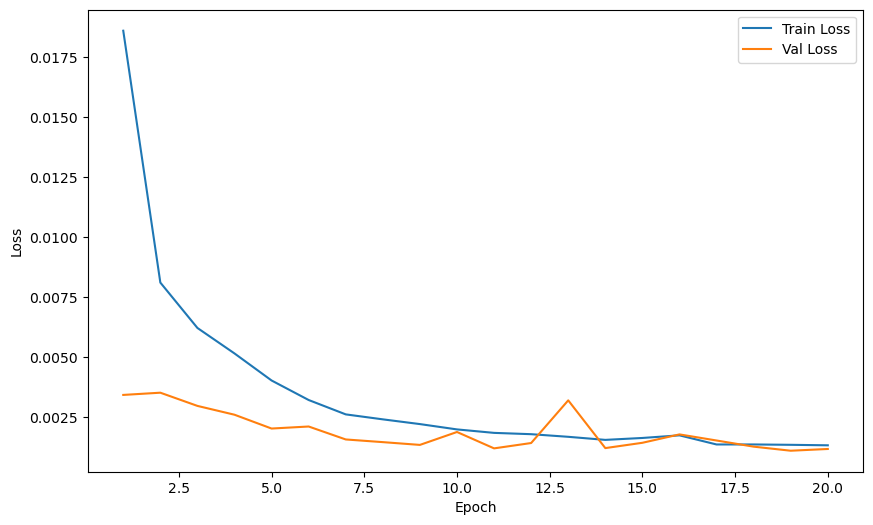

In [55]:
# 可视化损失函数
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
# 测试模型
model.eval()
predictions = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader ,position=0):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        predictions.extend(outputs.cpu().numpy())

predictions = np.array(predictions).reshape(-1, 1)
labels = (testY.cpu().numpy()).reshape(-1, 1)

#测试集数据反归一化
predictions = scaler2.inverse_transform(predictions)
labels = scaler2.inverse_transform(labels)

100%|██████████| 21/21 [00:00<00:00, 108.69it/s]


In [57]:
# 计算模型的评价指标
r2 = r2_score(labels, predictions)
mae = mean_absolute_error(labels, predictions)
rmse = np.sqrt(mean_squared_error(labels, predictions))

# 打印模型的评价指标
print('R^2:', r2)
print('MAE:', mae)
print('RMSE:', rmse)

R^2: 0.7418708308077675
MAE: 0.00042007427
RMSE: 0.00065061945


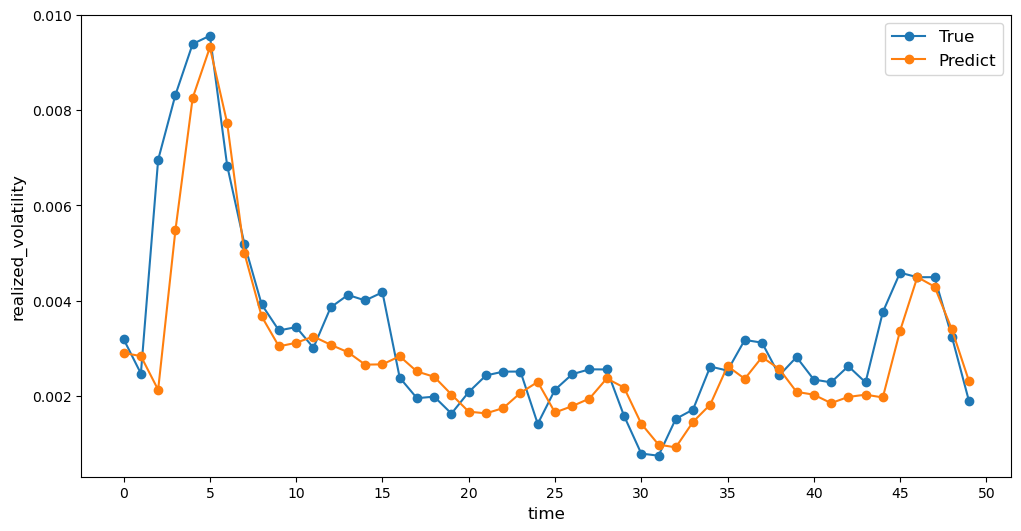

In [64]:
n = 50
labels_subset = labels[-n:]
predictions_subset = predictions[-n:]

plt.figure(figsize=(12, 6))
plt.xlabel('time', fontsize=12)
plt.xticks(ticks=range(0, n + 1,5), labels=range(0,n + 1,5))
plt.ylabel('realized_volatility', fontsize=12)

# # 绘制真实值
# plt.plot(labels_subset, label='True', marker='o', markerfacecolor='none', markeredgecolor='blue', linestyle='-')
# # 绘制预测值
# plt.plot(predictions_subset, label='Predict', marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='-')

plt.plot(labels_subset, label='True', marker='o', linestyle='-')
plt.plot(predictions_subset, label='Predict', marker='o', linestyle='-')

plt.legend(fontsize=12)
plt.show()

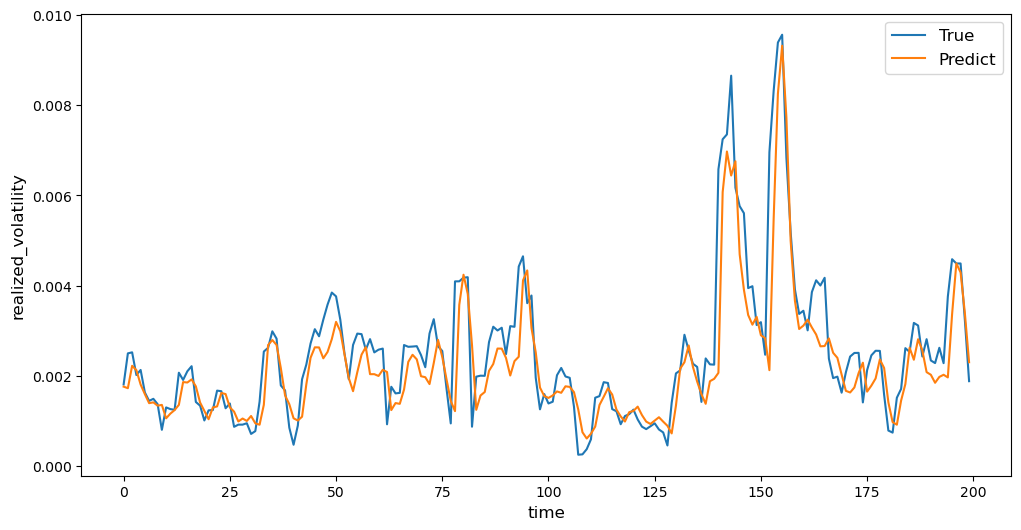

In [66]:
# 假设 labels 和 predictions 是包含所有数据的列表或数组
# 只展示前200条数据
n = 200
labels_subset = labels[-n:]
predictions_subset = predictions[-n:]

plt.figure(figsize=(12, 6))
plt.xlabel('time', fontsize=12)
plt.ylabel('realized_volatility', fontsize=12)
plt.plot(labels_subset, label='True')
plt.plot(predictions_subset, label='Predict')
plt.legend(fontsize=12)
plt.show()

In [68]:
multi_step = 5

In [70]:
testX_multi, testY_multi = create_dataset(test_X, test_Y, look_back, pred_forward=multi_step)

In [72]:
testX_multi = torch.Tensor(testX_multi)
testY_multi = torch.Tensor(testY_multi)

In [74]:
test_dataset_multi = MyDataset(testX_multi, testY_multi)

In [76]:
test_loader_multi = DataLoader(test_dataset_multi, batch_size=batch_size, shuffle=False)

In [78]:
# 测试模型
model.eval()
predictions = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader_multi ,position=0):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model.predict_multi_step(inputs,steps=multi_step)

        predictions.extend(outputs.cpu().numpy())

predictions = np.array(predictions).reshape(-1, 1)
labels = (testY_multi.cpu().numpy()).reshape(-1, 1)

#测试集数据反归一化
predictions = scaler2.inverse_transform(predictions)
labels = scaler2.inverse_transform(labels)

100%|██████████| 5/5 [00:00<00:00, 30.99it/s]


In [80]:
# 计算模型的评价指标
r2 = r2_score(labels, predictions)
mae = mean_absolute_error(labels, predictions)
rmse = np.sqrt(mean_squared_error(labels, predictions))
# mape = np.mean(np.abs((labels - predictions) / labels))

# 打印模型的评价指标
print('R^2:', r2)
print('MAE:', mae)
print('RMSE:', rmse)
# print('MAPE:', mape)

R^2: 0.20929522102108422
MAE: 0.0007314507
RMSE: 0.0011395802


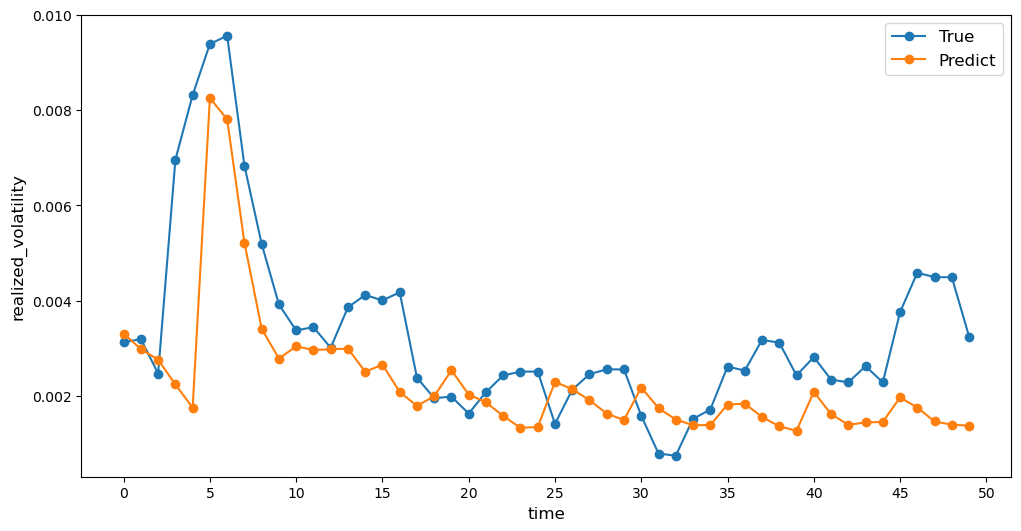

In [82]:
n = 50
labels_subset = labels[-n:]
predictions_subset = predictions[-n:]

plt.figure(figsize=(12, 6))
plt.xlabel('time', fontsize=12)
plt.xticks(ticks=range(0, n + 1,5), labels=range(0,n + 1,5))
plt.ylabel('realized_volatility', fontsize=12)

# # 绘制真实值
# plt.plot(labels_subset, label='True', marker='o', markerfacecolor='none', markeredgecolor='blue', linestyle='-')
# # 绘制预测值
# plt.plot(predictions_subset, label='Predict', marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='-')

plt.plot(labels_subset, label='True', marker='o', linestyle='-')
plt.plot(predictions_subset, label='Predict', marker='o', linestyle='-')

plt.legend(fontsize=12)
plt.show()

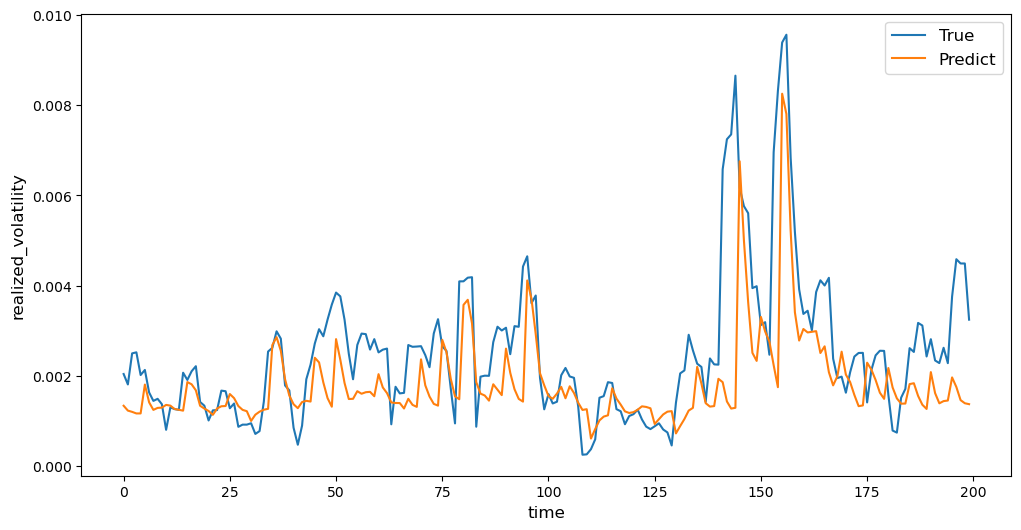

In [84]:
# 假设 labels 和 predictions 是包含所有数据的列表或数组
# 只展示前200条数据
n = 200
labels_subset = labels[-n:]
predictions_subset = predictions[-n:]

plt.figure(figsize=(12, 6))
plt.xlabel('time', fontsize=12)
plt.ylabel('realized_volatility', fontsize=12)
plt.plot(labels_subset, label='True')
plt.plot(predictions_subset, label='Predict')
plt.legend(fontsize=12)
plt.show()